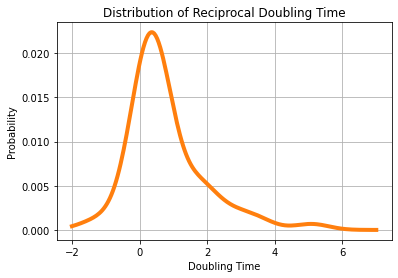

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, binom
from scipy.interpolate import interp1d
from py_scripts.common import QuantitiesOfInterest

rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

# Generate a kde on 201 points out of above data and plot it
rdt_range = np.linspace(-2, 7, 201)
dist = pd.Series(
    gaussian_kde(rdts).pdf(rdt_range),
    index=rdt_range,
    name="prob"
)
dist.index.name = "rdt"

dist /= dist.sum()

_ = dist.plot(
    title="Distribution of Reciprocal Doubling Time", lw=4, color="C1", grid=True,
    xlabel="Doubling Time", ylabel="Probability"
)

The expected value is: 20.55365104237588
The MAP is: 17.24137931034483
The CI is: [14.482758620689657, 28.965517241379313]


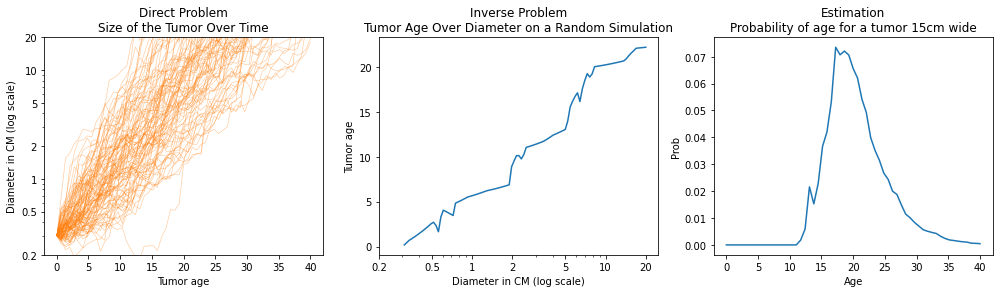

In [2]:
def grow(rdts, initial_diameter=.3):
    """Grow a tumor given an array of growth rates."""
    initial =((initial_diameter/2)**3) * np.pi * 4/3  # initial volume
    growth = [initial, ]
    for n, rdt in enumerate(rdts[1:]):
        new_volume = growth[n] * 2**(rdt*interval)
        growth.append(new_volume)
    return growth

def estimate_age_out_of_size(size, probs_df):
    """Given a dataframe of probabilities, calculate the pdf of the age."""
    valid_sizes = probs_df.columns.values
    closest_index = np.abs(valid_sizes - size).argmin()
    x = valid_sizes[closest_index].round(2)
    values = probs_df.iloc[:, closest_index].copy()
    values /= values.sum()
    return values

## Direct Problem ##
####################

# Run one simulation that starts at 0.3 and runs until 40 years are reached assuming a
# measurement every 245 days and calculating the volume at each step by drawing a value 
# from above distribution
# The result should be a df with diameter simulations grow over time (index)
np.random.seed(17)
interval = 245 / 365
dist_df = dist.reset_index()
measurements = np.linspace(0, 40, int(40 / interval))

# We start by generating a grid of random variates that we'll use to grow the simulations
sims = 100
sample_size = measurements.size * sims
sample_shape = sims, measurements.size  # ~100x59
weights = dist_df.prob.values
samples = (
    dist_df.rdt
    .sample(sample_size, weights=weights, replace=True)
    .values
    .reshape(sample_shape)  # reshape as a 2d-grid
)
volumes = np.array([grow(s) for s in samples])
diameters = 2 * (volumes * 3 / (4*np.pi))**(1/3)
diameter_cols = [f"d{n}" for n in range(sims)]
simulation = pd.DataFrame(diameters.T, index=measurements, columns=diameter_cols)

## Inverse Problem ##
#####################

# Interpolate the value of age for a single simulation
diameter_space = np.logspace(np.log2(.31), np.log2(20), 100, base=2)
ages, sizes = simulation.d1, simulation.index
f = interp1d(ages, sizes)
ages_per_diameter = f(diameter_space)
ages_per_diameter_sample = pd.Series(ages_per_diameter, index=diameter_space)

# Build a df with the joint probabilities of ages and sizes
diameter_space = np.logspace(np.log2(.2), np.log2(20), 300, base=2)
probs_df = simulation.copy()
probs_df = probs_df.apply(
    lambda row: gaussian_kde(row).pdf(diameter_space), axis=1, result_type='expand'
)
probs_df.columns = diameter_space

# Run some estimation
size = 15
estimate = estimate_age_out_of_size(size, probs_df)
QuantitiesOfInterest(estimate).run()

# Plot everything
_, ax = plt.subplots(ncols=3, figsize=(17,4))
simulation.plot(
    color="C1", legend=False, alpha=.5, lw=.5, logy=True, ylim=(.2, 20), ax=ax[0],
    xlabel="Tumor age", ylabel="Diameter in CM (log scale)",
    title="Direct Problem\nSize of the Tumor Over Time",
)
yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
ax[0].set_yticks(yticks, yticks)

ages_per_diameter_sample.plot(
    xlabel="Diameter in CM (log scale)", ylabel="Tumor age", ax=ax[1], logx=True,
    title="Inverse Problem\nTumor Age Over Diameter on a Random Simulation",
)
ax[1].set_xticks(yticks, yticks)

_ = estimate.plot(
    xlabel="Age", ylabel="Prob", ax=ax[2],
    title=f"Estimation\nProbability of age for a tumor {size}cm wide",
)

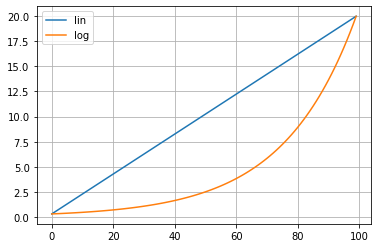

In [3]:
# investigating np.logspace
import numpy as np
import pandas as pd
start, end, steps = .3, 20, 100
_ = pd.DataFrame({
    "lin": np.linspace(start, end, steps),
    "log": np.logspace(np.log2(start), np.log2(end), steps, base=2),
}).plot(grid=True)

In [4]:
sq_total, sq_count, yeast = 25, 5, 49

# Create a pymc model with the intia

billion = 1e9
count_ratio = sq_total / sq_count
capacity = 1e-4  # the hemocytometer capacity in mL
dilution_factor = 1e3  # 3 step reduction

raw_estimation = yeast * count_ratio * dilution_factor / capacity  # 2.45 billion

with pm.Model() as model:
    # This bit represents the information we want to find out. It seems that the amounts
    # might come from the raw estimation. In any case after performing the updates we can
    # verify whether these are reasonable assumptions
    yeast_conc = pm.Normal("concentration", mu=2 * billion, sd=0.4 * billion)

    # This bit accounts for the variations in the volume of water we add to the shakers
    # mu is calculated out of what we expect to be the volume of water, 9mL, the .05 sd
    # adds the amount of noise but it feels like an arbitrary value
    shaker1_volume = pm.Normal("shaker1 volume (mL)", mu=9.0, sd=0.05)
    shaker2_volume = pm.Normal("shaker2 volume (mL)", mu=9.0, sd=0.05)
    shaker3_volume = pm.Normal("shaker3 volume (mL)", mu=9.0, sd=0.05)

    # This bit accounts for the volume variations to complement the water in the shakers,
    # On average we expect to be adding 1mL but that can vary by some sd which again feels
    # like an arbitrary value.
    yeast_slurry_volume = pm.Normal("initial yeast slurry volume (mL)", mu=1.0, sd=0.01)
    shaker1_to_shaker2_volume = pm.Normal("shaker1 to shaker2 (mL)", mu=1.0, sd=0.01)
    shaker2_to_shaker3_volume = pm.Normal("shaker2 to shaker3 (mL)", mu=1.0, sd=0.01)

    # Compute ratio of yeast in each of the shakers and then the total ratio
    dilution_shaker1 = yeast_slurry_volume / (yeast_slurry_volume + shaker1_volume)
    dilution_shaker2 = (
        shaker1_to_shaker2_volume / (shaker1_to_shaker2_volume + shaker2_volume)
    )
    dilution_shaker3 = (
        shaker2_to_shaker3_volume / (shaker2_to_shaker3_volume + shaker3_volume)
    )
    final_dilution_factor = dilution_shaker1 * dilution_shaker2 * dilution_shaker3

    # This bit accounts for variances in the manufacturer of the hemocytometer
    volume_of_chamber = pm.Gamma("volume of chamber (mL)", mu=0.0001, sd=0.0001 / 20)

    # why is Poisson justified? 
    # Because we have a very high concentrations of yeast (kind of billions) but the
    # probability is quite low as the shaker content is mostly water after all the 
    # dilutions
    yeast_visible = pm.Poisson(
        "cells in hemocytometer", 
        mu=yeast_conc * final_dilution_factor * volume_of_chamber
    )
    # Finally, the likelihood of the observations is a binomial that says that we will
    # watch some yeast_visible with probability 1/5 as we are not counting all the squares
    count = pm.Binomial("counts", n=yeast_visible, p=sq_count/sq_total, observed=yeast)

    trace = pm.sample(2000, return_inferencedata=False)
    s = az.summary(trace)
s

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [volume of chamber (mL), shaker2 to shaker3 (mL), shaker1 to shaker2 (mL), initial yeast slurry volume (mL), shaker3 volume (mL), shaker2 volume (mL), shaker1 volume (mL), concentration]
>Metropolis: [cells in hemocytometer]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
concentration,2.269263e+09,2.590222e+08,1.771829e+09,2.749300e+09,1.513148e+07,1.071024e+07,291.0,925.0,1.02
shaker1 volume (mL),8.999000e+00,4.900000e-02,8.903000e+00,9.088000e+00,1.000000e-03,0.000000e+00,5276.0,2899.0,1.00
shaker2 volume (mL),8.999000e+00,5.000000e-02,8.906000e+00,9.092000e+00,1.000000e-03,0.000000e+00,5384.0,3214.0,1.00
shaker3 volume (mL),9.000000e+00,4.900000e-02,8.910000e+00,9.093000e+00,1.000000e-03,1.000000e-03,4478.0,2575.0,1.00
initial yeast slurry volume (mL),1.000000e+00,9.000000e-03,9.820000e-01,1.017000e+00,0.000000e+00,0.000000e+00,5594.0,3292.0,1.00
shaker1 to shaker2 (mL),1.000000e+00,1.000000e-02,9.820000e-01,1.019000e+00,0.000000e+00,0.000000e+00,4865.0,2961.0,1.00
shaker2 to shaker3 (mL),1.001000e+00,1.000000e-02,9.830000e-01,1.019000e+00,0.000000e+00,0.000000e+00,5069.0,3086.0,1.00
cells in hemocytometer,2.317360e+02,2.475200e+01,1.850000e+02,2.770000e+02,1.928000e+00,1.365000e+00,163.0,297.0,1.02
volume of chamber (mL),0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4084.0,3148.0,1.00


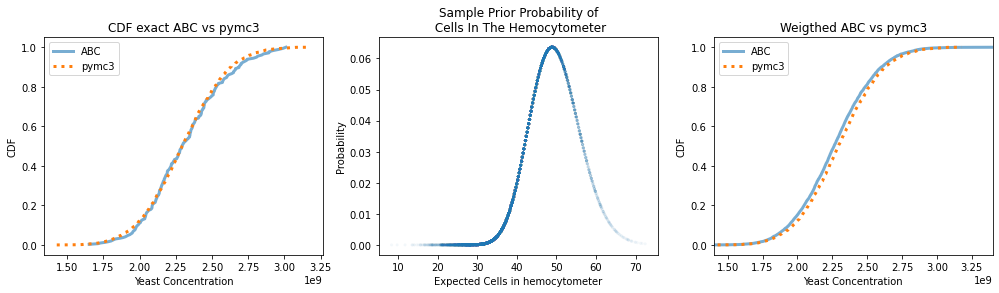

In [5]:
# We will run our ABC approximations by sampling from the priors
with model:
    prior = pm.sample_prior_predictive(10_000)

concentration = prior["concentration"]

## Exact Approach ##
####################

# As a first approach, we select all the data in `counts` prior that matches observations
target = prior["counts"] == yeast  # ~255

# Select all the data in the `concentration` prior that belongs to above selection
exact_conc = concentration[target].copy()
exact_conc.sort()
exact_conc_cdf = exact_conc.cumsum() / exact_conc.cumsum().max()

## Weighted Approach ##
#######################
# We'll build a binomial out of the probability count_ratio and the size of
# `cells in hemocytometer` prior sample.
p = 1 / count_ratio
counts = prior["cells in hemocytometer"]
likes = binom(n=counts, p=p).pmf(yeast)
abc = pd.Series(likes, index=concentration).sort_index().cumsum()
abc /= abc.max()

## Plot everything ##
#####################
# We'll need the traces from the posteriors in pymc to plot an overlap
pm_conc = trace["concentration"]
pm_conc.sort()
pm_conc_cdf = pm_conc.cumsum() / pm_conc.cumsum().max()

_, ax = plt.subplots(ncols=3, figsize=(17,4))
ax[0].set_title("CDF exact ABC vs pymc3")
ax[0].plot(exact_conc, exact_conc_cdf, lw=3, alpha=.6, color="C0", label="ABC")
ax[0].plot(pm_conc, pm_conc_cdf, lw=3, color="C1", ls=":", label="pymc3")
ax[0].legend()
ax[0].set_xlabel("Yeast Concentration")
ax[0].set_ylabel("CDF")

ax[1].scatter(counts*p, likes, sizes=np.full(counts.size, 5), alpha=.03)
ax[1].set_xlabel("Expected Cells in hemocytometer")
ax[1].set_ylabel("Probability")
ax[1].set_title("Sample Prior Probability of\n Cells In The Hemocytometer")

abc.plot(
    xlabel="Yeast Concentration", ylabel="CDF", title="Weigthed ABC vs pymc3",
    lw=3, alpha=.6, color="C0", label="ABC", ax=ax[2], xlim=(1.4*billion, 3.4*billion)
)
ax[2].plot(pm_conc, pm_conc_cdf, lw=3, color="C1", ls=":", label="pymc3")
_ = ax[2].legend()